# Stock Return Prediction: Model Comparison

This notebook compares several models for stock return prediction and evaluates their out-of-sample performance with multiple metrics (RMSE, MAE, Hit Ratio, R2_OOS, DM, CW).

In [4]:
# Imports and configuration
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wrds
from dotenv import load_dotenv
from datetime import datetime

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set(style="whitegrid")
np.random.seed(42)

# Load environment variables (optional: WRDS_USER)
load_dotenv()

True

In [5]:
# Data: Fetch MSFT daily prices from WRDS CRSP and compute returns
start, end = datetime(2005, 1, 1), datetime(2022, 12, 31)
wrds_user = os.getenv("WRDS_USER", None)
conn = wrds.Connection(wrds_username=wrds_user)

sql = f"""
WITH msft_perm AS (
  SELECT DISTINCT permno
  FROM crsp.stocknames
  WHERE ticker = 'MSFT'
)
SELECT
  dsf.date,
  dsf.permno,
  ABS(dsf.prc) AS prc,
  dsf.cfacpr,
  dsf.cfacshr
FROM crsp.dsf AS dsf
JOIN msft_perm ap ON dsf.permno = ap.permno
WHERE dsf.date BETWEEN '{start:%Y-%m-%d}' AND '{end:%Y-%m-%d}'
ORDER BY dsf.date;
"""

px = conn.raw_sql(sql, date_cols=["date"]) 
conn.close()

# Adjusted close using CRSP price and price adjustment factor (cfacpr)
px = px.sort_values('date')
px['adj_close'] = px['prc'] * px['cfacpr']
px['ret'] = px['adj_close'].pct_change()
px = px.dropna(subset=['ret']).set_index('date')
px.tail()

Loading library list...
Done


,permno,prc,cfacpr,cfacshr,adj_close,ret
date,,,,,,
2022-12-23,10107,238.73,1.0,1.0,238.73,0.002267
2022-12-27,10107,236.96001,1.0,1.0,236.96001,-0.007414
2022-12-28,10107,234.53,1.0,1.0,234.53,-0.010255
2022-12-29,10107,241.00999,1.0,1.0,241.00999,0.02763
2022-12-30,10107,239.82001,1.0,1.0,239.82001,-0.004937


In [6]:
# Feature engineering
win_short, win_long = 5, 21

# Lags
px['ret_lag1'] = px['ret'].shift(1)

# Moving averages and momentum proxies
px['ma_short'] = px['adj_close'].rolling(win_short).mean()
px['ma_long']  = px['adj_close'].rolling(win_long).mean()
px['ma_gap']   = px['ma_short'] / px['ma_long'] - 1
px['mom_21']   = px['adj_close'].pct_change(21)

# Volatility (rolling std of returns)
px['vol_21'] = px['ret'].rolling(21).std()

# RSI(14)
delta = px['adj_close'].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = (-delta.clip(upper=0)).rolling(14).mean()
rs = gain / (loss.replace(0, np.nan))
px['rsi14'] = 100 - (100 / (1 + rs))

# Target: next-day return
px['ret_fwd1'] = px['ret'].shift(-1)

# Clean
features = ['ret_lag1', 'ma_gap', 'mom_21', 'vol_21', 'rsi14']
df = px.dropna(subset=features + ['ret_fwd1']).copy()
df.tail()

,permno,prc,cfacpr,cfacshr,adj_close,ret,ret_lag1,ma_short,ma_long,ma_gap,mom_21,vol_21,rsi14,ret_fwd1
date,,,,,,,,,,,,,,
2022-12-22,10107,238.19,1.0,1.0,238.19,-0.025529,0.010877,241.911998,247.606665,-0.022999,-0.027915,0.021229,34.545443,0.002267
2022-12-23,10107,238.73,1.0,1.0,238.73,0.002267,-0.025529,240.719998,247.185237,-0.026155,-0.035746,0.021082,38.568857,-0.007414
2022-12-27,10107,236.96001,1.0,1.0,236.96001,-0.007414,0.002267,240.022000,246.683808,-0.027005,-0.042547,0.021119,41.293215,-0.010255
2022-12-28,10107,234.53,1.0,1.0,234.53,-0.010255,-0.007414,238.568000,246.339523,-0.031548,-0.029906,0.020651,39.864021,0.02763
2022-12-29,10107,241.00999,1.0,1.0,241.00999,0.02763,-0.010255,237.884000,246.371903,-0.034452,0.002829,0.021549,43.854583,-0.004937


In [7]:
# Train/test split by date (time-series aware)
split_date = '2018-01-01'
train = df.loc[:split_date].copy()
test  = df.loc[split_date:].copy()

X_train, y_train = train[features].values, train['ret_fwd1'].values
X_test,  y_test  = test[features].values,  test['ret_fwd1'].values

len(train), len(test)

(3250, 1258)

In [8]:
# Metrics: RMSE, MAE, Hit Ratio, R2_OOS, Diebold-Mariano, Clark-West
from math import sqrt
from scipy import stats


def rmse(y, yhat):
    return sqrt(np.mean((y - yhat)**2))


def mae(y, yhat):
    return np.mean(np.abs(y - yhat))


def hit_ratio(y, yhat):
    s_true = np.sign(y)
    s_pred = np.sign(yhat)
    return np.mean(s_true == s_pred)


def r2_oos(y_true, y_pred, y_train):
    mse_model = np.mean((y_true - y_pred)**2)
    mse_mean = np.mean((y_true - np.mean(y_train))**2)
    return 1 - mse_model / mse_mean


def dm_stat(y_true, y_pred, y_bench):
    d = (y_true - y_pred)**2 - (y_true - y_bench)**2
    d_mean = np.mean(d)
    d_std = np.std(d, ddof=1)
    return d_mean / (d_std / np.sqrt(len(d)))


def cw_stat(y_true, y_pred, y_bench):
    f_hat = y_pred - y_bench
    return np.mean((y_true - y_bench)**2 - (y_true - y_pred)**2 + f_hat**2)

In [9]:
# Models and evaluation
models = {
    'OLS': Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('reg', Ridge(alpha=1.0))]),
    'Lasso': Pipeline([('scaler', StandardScaler()), ('reg', Lasso(alpha=1e-3, max_iter=10000))]),
    'ElasticNet': Pipeline([('scaler', StandardScaler()), ('reg', ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=10000))]),
    'RandomForest': RandomForestRegressor(n_estimators=400, max_depth=None, random_state=42, n_jobs=-1),
    'GBDT': GradientBoostingRegressor(random_state=42),
    'SVR(RBF)': Pipeline([('scaler', StandardScaler()), ('reg', SVR(C=1.0, epsilon=0.001))]),
}

bench = np.full_like(y_test, np.mean(y_train))

rows = []
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    y_hat = mdl.predict(X_test)
    row = {
        'model': name,
        'RMSE': rmse(y_test, y_hat),
        'MAE': mae(y_test, y_hat),
        'HitRatio': hit_ratio(y_test, y_hat),
        'R2_OOS': r2_oos(y_test, y_hat, y_train),
        'DM': dm_stat(y_test, y_hat, bench),
        'CW': cw_stat(y_test, y_hat, bench),
    }
    rows.append(row)

res = pd.DataFrame(rows).sort_values('R2_OOS', ascending=False)
res

C:\Users\wangy\AppData\Local\Temp\ipykernel_37520\3811774362.py:30: RuntimeWarning: invalid value encountered in scalar divide
  return d_mean / (d_std / np.sqrt(len(d)))


,model,RMSE,MAE,HitRatio,R2_OOS,DM,CW
3,ElasticNet,0.019558,0.013630,0.532591,0.000469,-0.242135,2.950400e-07
2,Lasso,0.019562,0.013630,0.536566,0.000000,NaN,0.000000e+00
1,Ridge,0.019634,0.013681,0.525437,-0.007324,0.899917,-4.035878e-07
0,OLS,0.019634,0.013681,0.525437,-0.007343,0.901279,-4.062640e-07
6,SVR(RBF),0.020278,0.014409,0.523052,-0.074499,1.244490,5.359164e-05
4,RandomForest,0.020495,0.014211,0.501590,-0.097646,1.328113,4.014403e-05
5,GBDT,0.021705,0.014189,0.529412,-0.231091,1.822726,2.634286e-05


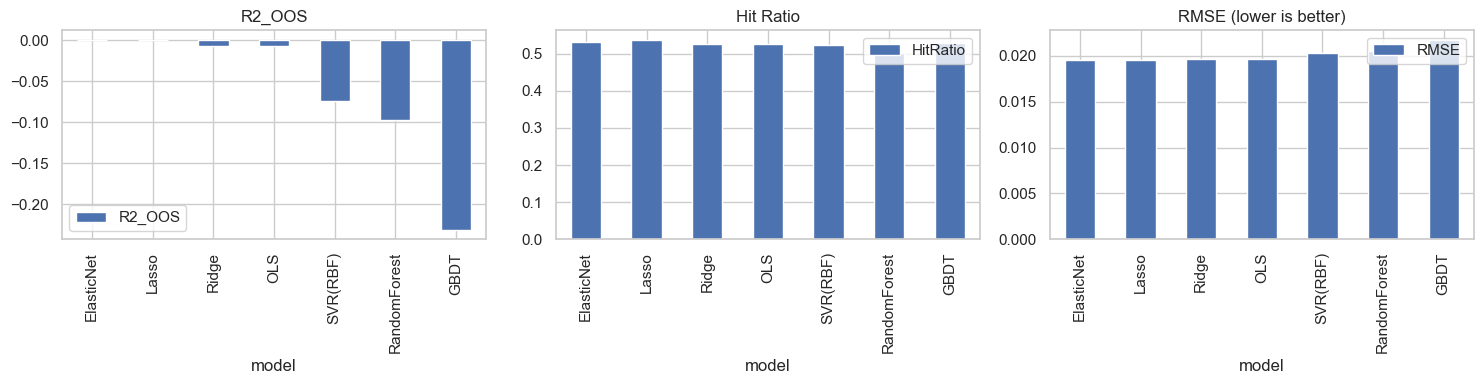

In [10]:
# Plot comparisons
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
res.plot(x='model', y='R2_OOS', kind='bar', ax=axes[0], title='R2_OOS')
res.plot(x='model', y='HitRatio', kind='bar', ax=axes[1], title='Hit Ratio')
res.plot(x='model', y='RMSE', kind='bar', ax=axes[2], title='RMSE (lower is better)')
plt.tight_layout()
plt.show()